# **Food Recognition**
Using the Kaggle Dataset: https://www.kaggle.com/datasets/kmader/food41


## Import all needed libraries

In [1]:
#For working with the data
import cv2 as cv
import os
import os.path
from pathlib import Path
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras


#For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing


#For visualisation
import matplotlib.pyplot as plt
import seaborn as sea


#For building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, MaxPool2D, Activation,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


#For analyzing the performance
from sklearn.metrics import confusion_matrix, classification_report



In [2]:
images = []
labels  = []
train_dir = '../input/food41/images'
image_size = (224,224) # define Image size
batch = 128           # define batch size


## Process the data

In [3]:
# Loop through the train file to get all the classes and the labels 

img_path = []
for filename in os.listdir(train_dir):
    img_dir = os.path.join(train_dir, filename)
    for image_file in os.listdir(img_dir):
        img_path.append(os.path.join(img_dir, image_file))
        labels.append(filename)



num_classes = np.unique(labels) 
lb = LabelEncoder()
labels = pd.DataFrame(labels)
labels = lb.fit_transform(labels[0])

img_path = np.array(img_path)
labels = np.array(labels, dtype = 'int32')

print(img_path.shape, len(images))  # print length of img_path
print(labels.shape, len(labels))

print(num_classes) # print all 101 classes including their labels

(101000,) 0
(101000,) 101000
['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheese_plate' 'cheesecake' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros' 'clam_chowder' 'club_sandwich' 'crab_cakes' 'creme_brulee'
 'croque_madame' 'cup_cakes' 'deviled_eggs' 'donuts' 'dumplings' 'edamame'
 'eggs_benedict' 'escargots' 'falafel' 'filet_mignon' 'fish_and_chips'
 'foie_gras' 'french_fries' 'french_onion_soup' 'french_toast'
 'fried_calamari' 'fried_rice' 'frozen_yogurt' 'garlic_bread' 'gnocchi'
 'greek_salad' 'grilled_cheese_sandwich' 'grilled_salmon' 'guacamole'
 'gyoza' 'hamburger' 'hot_and_sour_soup' 'hot_dog' 'huevos_rancheros'
 'hummus' 'ice_cream' 'lasagna' 'lobster_bisque' 'lobster_roll_sandwich'
 'macaroni_and_cheese' 'macarons' 'miso_soup' 'mussels' 'nachos'


## Visualize the Data

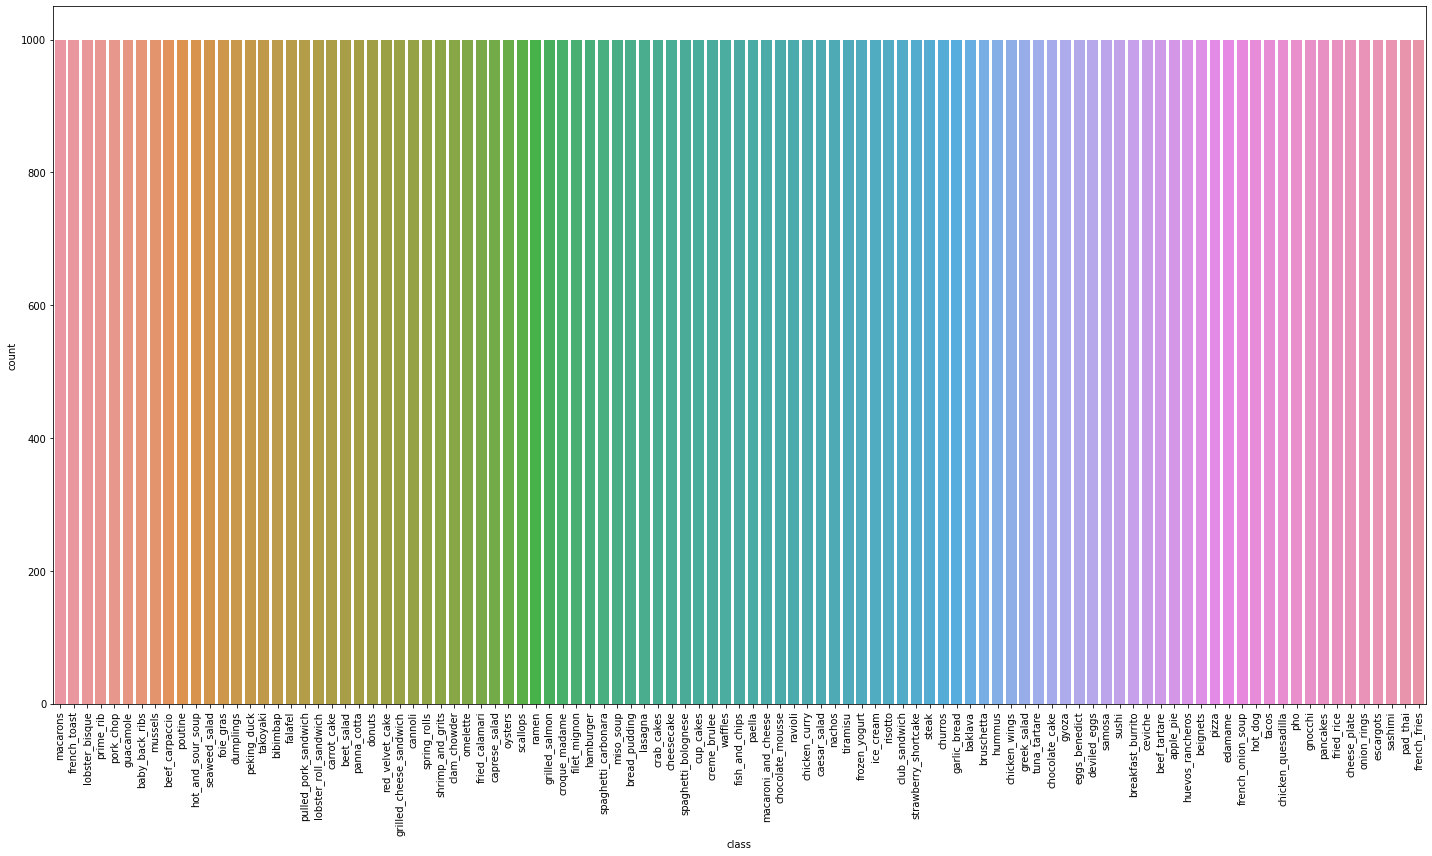

In [4]:
import seaborn as sea
## count number of images in each class for training data
DF = pd.DataFrame(columns=['class','count'])
DF['class']=pd.Series([os.listdir(train_dir)[x] for x in range(0,101)])
DF['count']=pd.Series([len(os.listdir(os.path.join(train_dir,os.listdir(train_dir)[x]))) for x in range(0,101)])
plt.figure(figsize=(20,12))
g=sea.barplot(x='class', y='count',data=DF)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()

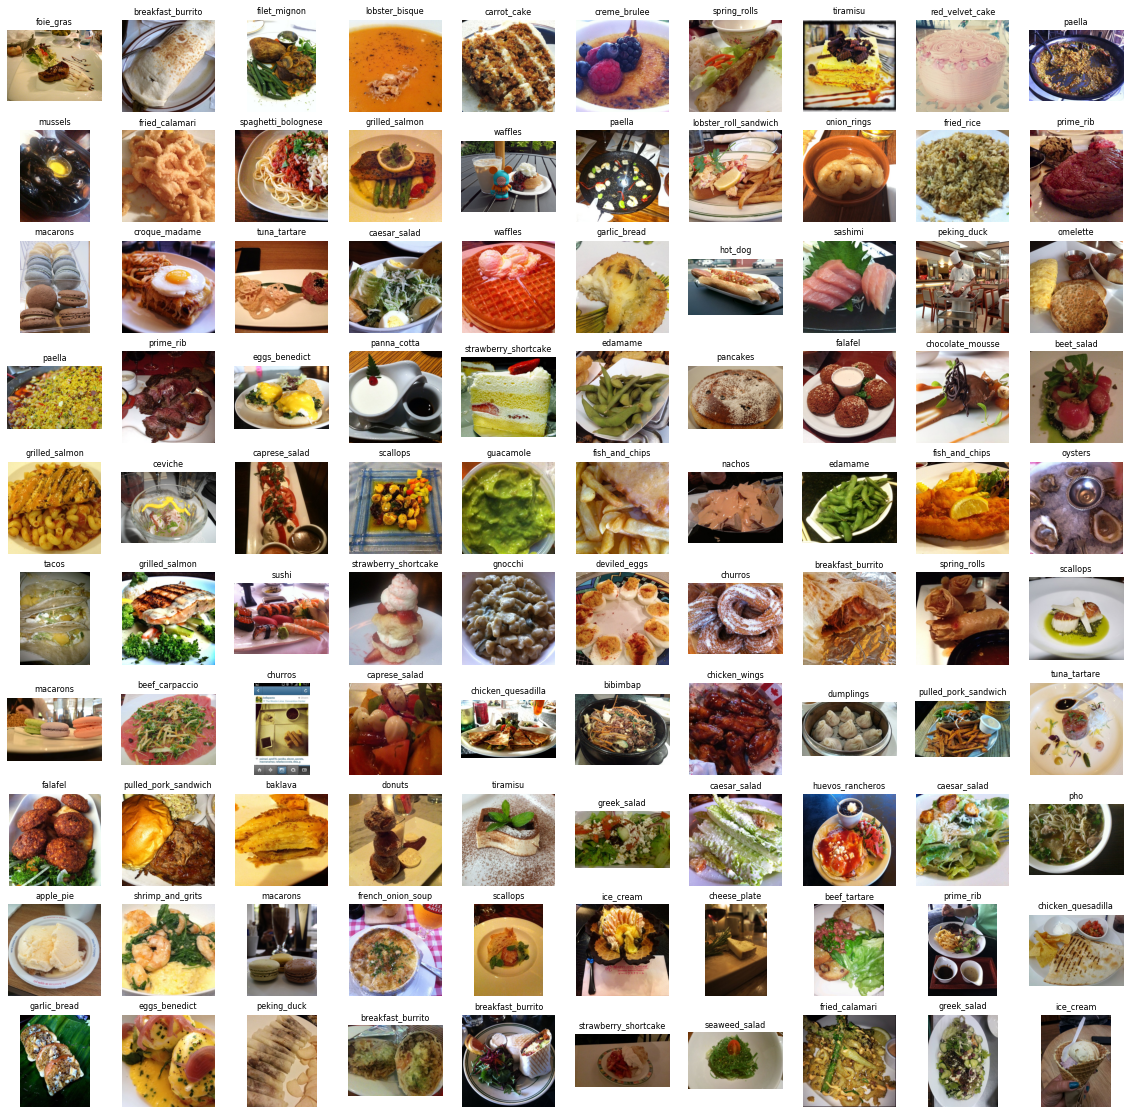

In [5]:
import random
import numpy as np

# visualize the training data
W = 10
H = 10
fig, axes = plt.subplots(W, H, figsize = (20,20))

axes = axes.ravel() # flaten the matrix into array
# Select a random number from 0 to n_training/ images will be selected randomly
for i in np.arange(0, W * H): 
    # Select a class randomly
    label = random.choice(os.listdir(train_dir))
    class_dir = os.path.join(train_dir,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    #print(np.array(img).shape)
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

In [6]:
# explore the image sizes
np.array(img).shape

(512, 384, 3)

## Split food dataset to 80% training data and 20% validation data

In [7]:

training_data= tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    image_size=(224, 224),
    batch_size= batch,
    shuffle = True,
    subset='training',
    seed = 101,
    label_mode = 'categorical',
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    image_size=(224, 224),
    batch_size= batch,
    shuffle = False,
    subset='validation',
    seed = 101,
    label_mode = 'categorical',
)



print(len(training_data))
print(len(validation_data))


Found 101000 files belonging to 101 classes.
Using 80800 files for training.


2022-07-14 08:04:52.521426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 08:04:52.656189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 08:04:52.657349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 08:04:52.661131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
632
158


# Model creation

In [8]:


# generator = tf.keras.preprocessing.image.ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=30,
#         shear_range=0.3,
#         horizontal_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.25,
# )

# Data augmentation to reduce overtraining
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.applications.EfficientNetB0(
            input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False,
            drop_connect_rate=0.5
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(101, activation='softmax') # use softmax 
      #101 is for the number of classes in the dataset
])

16719872/16705208 [==============================] - 1s 0us/step


In [9]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(
    training_data, 
    validation_data=validation_data,
    epochs= 15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            #when the validation loss stops improving for three consecutive epochs, we'll stop
            #training and restore the weights from the best epoch
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15


2022-07-14 08:05:17.183828: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-14 08:05:26.175259: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


632/632 [==============================] - 670s 1s/step - loss: 1.6129 - accuracy: 0.5913 - val_loss: 1.3763 - val_accuracy: 0.6239
Epoch 2/15
632/632 [==============================] - 621s 978ms/step - loss: 0.9790 - accuracy: 0.7365 - val_loss: 1.0896 - val_accuracy: 0.6964
Epoch 3/15
632/632 [==============================] - 623s 981ms/step - loss: 0.8141 - accuracy: 0.7747 - val_loss: 1.0904 - val_accuracy: 0.6981
Epoch 4/15
632/632 [==============================] - 619s 976ms/step - loss: 0.7009 - accuracy: 0.8024 - val_loss: 0.9333 - val_accuracy: 0.7340
Epoch 5/15
632/632 [==============================] - 619s 976ms/step - loss: 0.6126 - accuracy: 0.8252 - val_loss: 1.0265 - val_accuracy: 0.7182
Epoch 6/15
632/632 [==============================] - 620s 977ms/step - loss: 0.5413 - accuracy: 0.8429 - val_loss: 0.7390 - val_accuracy: 0.7882
Epoch 7/15
632/632 [==============================] - 621s 979ms/step - loss: 0.4797 - accuracy: 0.8576 - val_loss: 1.1637 - val_accuracy:

## Evaluate Model

In [10]:
scores = model.evaluate(validation_data)
print('Loss:', scores[0]*100)
print('Accuracy:', scores[1]*100)

158/158 [==============================] - 53s 337ms/step - loss: 0.6715 - accuracy: 0.8138
Loss: 67.14544296264648
Accuracy: 81.38118982315063


## Plot Results

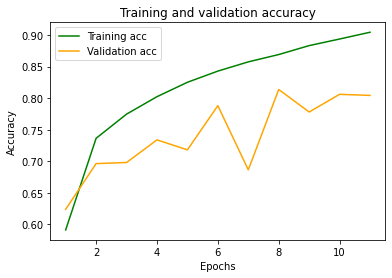

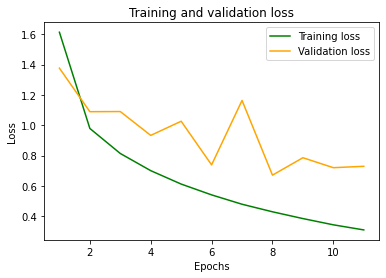

In [11]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()